# Kaggle competition - Final model

##### Reminder for the baseline model conclusions & next steps

We used a baseline model of lightGBM with various feature ideas we had.

This was just a "bruteforce" model to test all the "simple" features and ideas we had for splitting the data and creating an initial baseline model that we should analyze furtherly and improve.

We did not tackle multiple gaps that we plan to tackle in the final model:

1. Leakage - After a brainstorm on the "too good" performance we got, we found that we have a leakage in the count unique features (which also count validation / test appearances and not just on the history - we can only count train appearances to evaluate such features), we will fix their calculation to use only "history" per click and it's entities - will be fixed in our final model (next task)!
2. Time based cross validation and parameters tuning - We need to think on the CV folds strategy, how we handle the time gap in the data (see bullet #2 here), using optimization frameworks like optuna, thinking on "how long" do we want to look back in the history we have when we calculate our features.
3. Sample weights - As we mentioned in our EDA, we would like to give different weight to different samples (here we only increased the positive sample weights), we need to think on the strategy here, some ideas we had:
    - Giving bigger sample weight to samples near the train end (as they are the closest to the test set).
    - Evaluating different weights over time (older samples - lower weight, newest - bigger weights). 
4. Feature selection - 
    - We did not use any feature selection here - We implemented multiple features as as we saw in the correlation matrix, there is a very high correlation in multiple features. In addition, we did not perform feature analysis to the features we created (correlation with the label for example, binning evaluation, etc.). 
    - We can already see from feature importance chart that there is very strong affect for time based features and combinations/aggregative features. We could continue analyzing it before choosing the final model.
5. Error analysis - We did not perform any error analysis here and another iteration of the model - We plan to analyze the samples where we had mistakes, maybe adding additional features for them (we can use SHAP in our case).
6. Stacking - Based on the error analysis, we might want to consider stacking different models / creating sub-models for specific phenomenas and combining the results of multiple models.


##### Baseline model code

In [1]:
# Imports
import gc
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
sns.set_palette("coolwarm")
sns.set_theme()
sns.set(rc={'figure.figsize':(10,5)})

seed=42

In [3]:
logger_conf = logging.basicConfig(level=logging.INFO,
                             format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
                             datefmt="%m/%d/%Y %I:%M:%S%p")

LOGGER = logging.getLogger('BasicLogger')


In [4]:
# Loading the datasets
columns_dtypes={'ip': np.uint32,
                'app': np.uint16,
                'device': np.uint16,
                'os': np.uint16,
                'channel': np.uint16}

test_df = pd.read_csv('./fraud-detection-clicks/test.csv', dtype=columns_dtypes)
test_df.sort_values('click_time', inplace=True)

columns_dtypes['is_attributed'] = np.uint8
train_sample_df = pd.read_csv('./fraud-detection-clicks/train_sample.csv', dtype=columns_dtypes)
train_df = pd.read_csv('./fraud-detection-clicks/train.csv', dtype=columns_dtypes)
train_df.sort_values('click_time', inplace=True)

train_df['click_id'] = np.nan
train_df['ds_type'] = 'train'
test_df['attributed_time'] = np.nan
test_df['is_attributed'] = np.nan
test_df['ds_type'] = 'test'

# We concat the datasets since test contains the period 1-2 hours after the train ends, we will use that to evaluate the test features that look on history
ds_df = pd.concat([train_df, test_df])



## Feature Extraction

#### Baseline model - FE code

##### Time features

Extracting features like the hour / minute / weekday / etc.

In [5]:
# Lets start with extracting day / hour features from dates
def extract_time_features(df):
    
    LOGGER.info(f"Evaluating click time features for dataframe in shape - {df.shape}")

    df['click_time_dt'] = pd.to_datetime(df['click_time'])

    df['click_time_wd'] = df.click_time_dt.dt.weekday.astype(np.uint8)

    df['click_time_h'] = df.click_time_dt.dt.hour.astype(np.uint8)
    df['click_time_rounded_hour'] = df.click_time_dt.dt.round('H')
    df['click_time_m'] = df.click_time_dt.dt.minute.astype(np.uint8)
    df['click_time_rounded_minute'] = df.click_time_dt.dt.round('min')

    LOGGER.info(f"New DF shape - {df.shape}\n")
       
    return df


##### Bins

We used these features to create bins for the different IP ranges.

In [6]:
def create_bins(df, binned_feature, bins, labels):

    LOGGER.info(f'Creating bins for feature: {binned_feature}')
    LOGGER.info(f'Bin values: {bins}')
    LOGGER.info(f'DF shape: {df.shape}')
    
    buckets_name = f'{binned_feature}_bucket'
    df[buckets_name] = pd.cut(df[binned_feature], bins, labels=labels)
    res = pd.get_dummies(data=df, columns=[buckets_name])

    one_hot_bin_features = [c for c in df.columns if c.startswith(f"{buckets_name}_")]

    for col in one_hot_bin_features:
        res[col] = res[col].astype(np.uint8)

    LOGGER.info(f'New DF shape: {res.shape}')

    return res


#### Profile based features
For example - For an IP, how many minutes / hours / clicks have I seen for it in the past

In [7]:
def extract_cumcount(df, group_by_features, counted_feature):
    # Evaluates a cummulative count that increases over time

    feature_name_past = f'{"_".join(group_by_features)}_{counted_feature}_past_cumcount'
    
    LOGGER.info(f'Creating cummulative count features for: {group_by_features + [counted_feature]}')
    LOGGER.info(f'Feature name: {[feature_name_past]}')
    LOGGER.info(f'DF shape: {df.shape}')
    
    # Count based on the history (values increase over time)
    past_cc_result = df[group_by_features+[counted_feature]].groupby(group_by_features)[counted_feature].cumcount()
    df[feature_name_past]=past_cc_result.values
    df[feature_name_past]=df[feature_name_past].astype(np.uint32)

    LOGGER.info(f'DF new shape: {df.shape}\n')

    return df


##### Count unique features

Reminder - In the baseline model we had a leakage in these features (as we counted future appearances as well!)

We need to modify this section - profile the unique counts based on train and use these number on the dataset with a join.

**The original code**

In [8]:
def extract_count_unique(df, group_by_features, counted_feature):
    # Evaluates a cummulative count that increases over time

    feature_name = f'{"_".join(group_by_features)}_{counted_feature}_cunique'
    LOGGER.info(f'Creating unique count features for: {group_by_features + [counted_feature]}')
    LOGGER.info(f'Feature name: {feature_name}')
    LOGGER.info(f'DF shape: {df.shape}')
    cu_result = df[group_by_features+[counted_feature]].groupby(group_by_features)[counted_feature].nunique().reset_index().rename(columns={counted_feature: feature_name})
    df = df.merge(cu_result, how='left', on=group_by_features)
    df[feature_name] = df[feature_name].astype(np.uint32)
    LOGGER.info(f'DF new shape: {df.shape}\n')

    return df

**The new feature code**

To solve the leakage problem we had:

We evaluate the count unique values only on the train set and apply the values based on the keys in the dataframe (so we only profile known historic behavior)

In [9]:
def extract_count_unique_train_profile(train_df, group_by_features, counted_feature):
    # Evaluates a cummulative count that increases over time
    feature_name = f'{"_".join(group_by_features)}_{counted_feature}_cunique'
    LOGGER.info(f'Creating profile data of unique count features for: {group_by_features + [counted_feature]}')
    profile_result = train_df[group_by_features+[counted_feature]].groupby(group_by_features)[counted_feature].nunique().reset_index().rename(columns={counted_feature: feature_name})
    LOGGER.info(f'Profile data created for feature: {feature_name}')
    return profile_result

def extract_count_unique_v2(df, train_df, group_by_features, counted_feature):
    # This time we evaluate the count unique values only on the train set and apply the values based on the keys in the test set
    feature_name = f'{"_".join(group_by_features)}_{counted_feature}_cunique'
    LOGGER.info(f'Creating unique count features for: {group_by_features + [counted_feature]}')
    LOGGER.info(f'Feature name: {feature_name}')
    LOGGER.info(f'DF shape: {df.shape}')

    profile_result = extract_count_unique_train_profile(train_df, group_by_features, counted_feature)
    df = df.merge(profile_result, how='left', on=group_by_features)
    df[feature_name].fillna(0, inplace=True)
    df[feature_name] = df[feature_name].astype(np.uint32)
    LOGGER.info(f'DF new shape: {df.shape}\n')

    return df

#### New features

New feature ideas that we did not use in our baseline model

##### Time delta between clicks

For example - What id the diff in seconds between the previous click of - IP 1234 + OS - 567 



In [10]:
def extract_time_delta_features(df, group_by_features):

    LOGGER.info(f"Evaluating time delta features for dataframe in shape - {df.shape}")

    for gb_features in group_by_features:

        LOGGER.info(f"Evaluating time delta feature for columns - {gb_features}")

        gb_cols = gb_features + ['click_time_dt']

        prev_click_feature_name = f'{"_".join(gb_features)}_prev_click_delta'

        LOGGER.info(f"New feature name: {prev_click_feature_name}")

        gb_df = df.drop_duplicates(gb_cols)[gb_cols].sort_values(gb_cols)
        current_click = gb_df[['click_time_dt']]
        prev_click = current_click.shift(1)
        gb_df[prev_click_feature_name] = (current_click - prev_click).click_time_dt.dt.seconds.astype(np.float32)
        

        # Now we have the diff but for the first time the gb_cols appear we should have nulls and we have values instead, see:
        # DF
        # ip1, os1, ct1
        # ip1, os1, ct2
        # ip2, os1, ct3
        # ip2, os1, ct4

        # DF - Shift 1
        # ip1, os1, null
        # ip1, os1, ct1
        # ip2, os1, ct2 <- this should be null is ct 2 is a time of (ip1, os1) and not (ip2, os1)
        # ip2, os1, ct3

        df = df.merge(gb_df, how='left', on=gb_cols)
        
        df_first_seen = df.groupby(gb_features).agg({'click_time_dt': 'min'}).reset_index()
        df_first_seen['first_seen'] = True

        df = df.merge(df_first_seen, on=gb_cols, how='left')
        df.loc[df.first_seen == True, prev_click_feature_name] = np.nan

        df.drop('first_seen', axis=1, inplace=True)
                
        LOGGER.info(f"New DF shape - {df.shape}\n")    
    return df



##### Final model feature extraction full method

In [11]:
def feature_extraction_v2(df, train_df):

  # Click time based features
  df = extract_time_features(df)
  gc.collect()
  train_df = extract_time_features(train_df)
  gc.collect()

  # Time delta features - New features
  group_by_features = [
        ['ip'],
        ['ip', 'os', 'device'],
        ['ip', 'channel'],
        ['ip', 'os', 'device', 'channel'],
        ['ip', 'app'],
        ['ip', 'os', 'device', 'app'],
    ]

  df = extract_time_delta_features(df, group_by_features) 
  gc.collect()


  # IP Bins - Keeping the same as baseline
  ip_labels = [0, 12, 22, 28]
  ip_bins = [0, 120000, 220000, 280000, 370000]

  df = create_bins(df, 'ip', ip_bins, ip_labels)
  gc.collect()

  # Smaller IP bins - We've seen taht we had errors in our model around the IP bins of 0+12 (0-219999 values)
  # We evalute a different binning method here (smaller bins)
  ip_labels_v2 = [f'v2_{i}' for i in range(0, 37)]
  ip_bins_v2 = [i * 10000 for i in range(0, 38)]

  df = create_bins(df, 'ip', ip_bins_v2, ip_labels_v2)
  gc.collect()
  
  
  # Cummulative count features - We extend these features
  cumcount_combos = [
    # Original features
    {'gb_features': ['ip'], 'counted': 'channel'},
    {'gb_features': ['ip'], 'counted': 'os'},
    {'gb_features': ['ip'], 'counted': 'device'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'channel'},
    {'gb_features': ['ip'], 'counted': 'app'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'app'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'channel'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'app'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'os', 'device', 'channel'], 'counted': 'click_time_dt'},
    {'gb_features': ['ip', 'os', 'device', 'app'], 'counted': 'click_time_dt'},
  ]

  for cumcount_dict in cumcount_combos:
      df = extract_cumcount(df, group_by_features=cumcount_dict.get('gb_features'), counted_feature=cumcount_dict.get('counted'))
      gc.collect()
  
  # Count unique features
  cunique_combos = [
    {'gb_features': ['ip'], 'counted': 'channel'},
    {'gb_features': ['ip'], 'counted': 'app'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'channel'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'app'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device'], 'counted': 'click_time_rounded_minute'},
    
    # Combination count for the number of hours / minutes per weekday
    {'gb_features': ['ip', 'os', 'device', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_wd'], 'counted': 'click_time_rounded_hour'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_wd'], 'counted': 'click_time_rounded_minute'},

    # Combo counts of minutes per hour
    {'gb_features': ['ip', 'os', 'device', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'app', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'},
    {'gb_features': ['ip', 'os', 'device', 'channel', 'click_time_rounded_hour'], 'counted': 'click_time_rounded_minute'}
  ]
  
  for cunique_dict in cunique_combos:
      df = extract_count_unique_v2(df, train_df, group_by_features=cunique_dict.get('gb_features'), counted_feature=cunique_dict.get('counted'))
      gc.collect()

  return df
    

We split the full dataset 2 times:
1. Train / validation set
2. Train / test set

We've modified the split point from 0.9 -> 0.86 (in order to have a full hour in the validation set - similar to the train-test split where test had 1 hour)

In [13]:
# Splitting the train to train-validation with last hour out split (to mimic the one hour that is in the test set after the training set)

# We leave a small gap between train and validation to avoid leakage of similar sessions
train_val_base = ds_df[ds_df.ds_type=='train'].copy()
train_val_size = train_val_base.shape[0]

# Split to train and validation
train_end = round(train_val_size * 0.86) # 0.86 leaves about 1 hour to the validation set
validation_start = round(train_val_size * 0.8605)
train_val_train_only = train_val_base[:train_end].copy()

train_validation_df = feature_extraction_v2(train_val_base.copy(), train_val_train_only)
train_validation_df.to_pickle(f'./datasets/ds_train_val_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')


train_test_df = feature_extraction_v2(ds_df.copy(), train_val_base)
train_test_df[train_test_df.ds_type=='train'].to_pickle(f'./datasets/ds_full_train_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')
train_test_df[train_test_df.ds_type=='test'].to_pickle(f'./datasets/ds_full_test_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')


01/31/2022 01:37:09PM | INFO | BasicLogger | Evaluating click time features for dataframe in shape - (26877324, 10)
01/31/2022 01:37:19PM | INFO | BasicLogger | New DF shape - (26877324, 16)

01/31/2022 01:37:20PM | INFO | BasicLogger | Evaluating click time features for dataframe in shape - (23114499, 10)
01/31/2022 01:37:28PM | INFO | BasicLogger | New DF shape - (23114499, 16)

01/31/2022 01:37:28PM | INFO | BasicLogger | Evaluating time delta features for dataframe in shape - (26877324, 16)
01/31/2022 01:37:28PM | INFO | BasicLogger | Evaluating time delta feature for columns - ['ip']
01/31/2022 01:37:28PM | INFO | BasicLogger | New feature name: ip_prev_click_delta
01/31/2022 01:38:42PM | INFO | BasicLogger | New DF shape - (26877324, 17)

01/31/2022 01:38:42PM | INFO | BasicLogger | Evaluating time delta feature for columns - ['ip', 'os', 'device']
01/31/2022 01:38:42PM | INFO | BasicLogger | New feature name: ip_os_device_prev_click_delta
01/31/2022 01:40:05PM | INFO | BasicLogg

**Checking for nulls after FE**

In [14]:
print(train_validation_df.info(null_counts=True))

/var/folders/hp/1nwbq3_d6233ql5yg61wlxg02r6qjf/T/ipykernel_42527/229503021.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(train_validation_df.info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 26877324 entries, 0 to 26877323
Data columns (total 94 columns):
 #   Column                                                                          Non-Null Count     Dtype         
---  ------                                                                          --------------     -----         
 0   ip                                                                              26877324 non-null  uint32        
 1   app                                                                             26877324 non-null  uint16        
 2   device                                                                          26877324 non-null  uint16        
 3   os                                                                              26877324 non-null  uint16        
 4   channel                                                                         26877324 non-null  uint16        
 5   click_time                                     

In [15]:
train_validation_df.columns.tolist()

['ip',
 'app',
 'device',
 'os',
 'channel',
 'click_time',
 'attributed_time',
 'is_attributed',
 'click_id',
 'ds_type',
 'click_time_dt',
 'click_time_wd',
 'click_time_h',
 'click_time_rounded_hour',
 'click_time_m',
 'click_time_rounded_minute',
 'ip_prev_click_delta',
 'ip_os_device_prev_click_delta',
 'ip_channel_prev_click_delta',
 'ip_os_device_channel_prev_click_delta',
 'ip_app_prev_click_delta',
 'ip_os_device_app_prev_click_delta',
 'ip_bucket_0',
 'ip_bucket_12',
 'ip_bucket_22',
 'ip_bucket_28',
 'ip_bucket_v2_0',
 'ip_bucket_v2_1',
 'ip_bucket_v2_2',
 'ip_bucket_v2_3',
 'ip_bucket_v2_4',
 'ip_bucket_v2_5',
 'ip_bucket_v2_6',
 'ip_bucket_v2_7',
 'ip_bucket_v2_8',
 'ip_bucket_v2_9',
 'ip_bucket_v2_10',
 'ip_bucket_v2_11',
 'ip_bucket_v2_12',
 'ip_bucket_v2_13',
 'ip_bucket_v2_14',
 'ip_bucket_v2_15',
 'ip_bucket_v2_16',
 'ip_bucket_v2_17',
 'ip_bucket_v2_18',
 'ip_bucket_v2_19',
 'ip_bucket_v2_20',
 'ip_bucket_v2_21',
 'ip_bucket_v2_22',
 'ip_bucket_v2_23',
 'ip_bucket_v2

##### Features correlation
Reminder - We've seen in the baseline model that we have multiple features with high correlation, let's try to find them now and evaluate the model performance with deifferent feature sets (we will drop some of the highly correlated features).

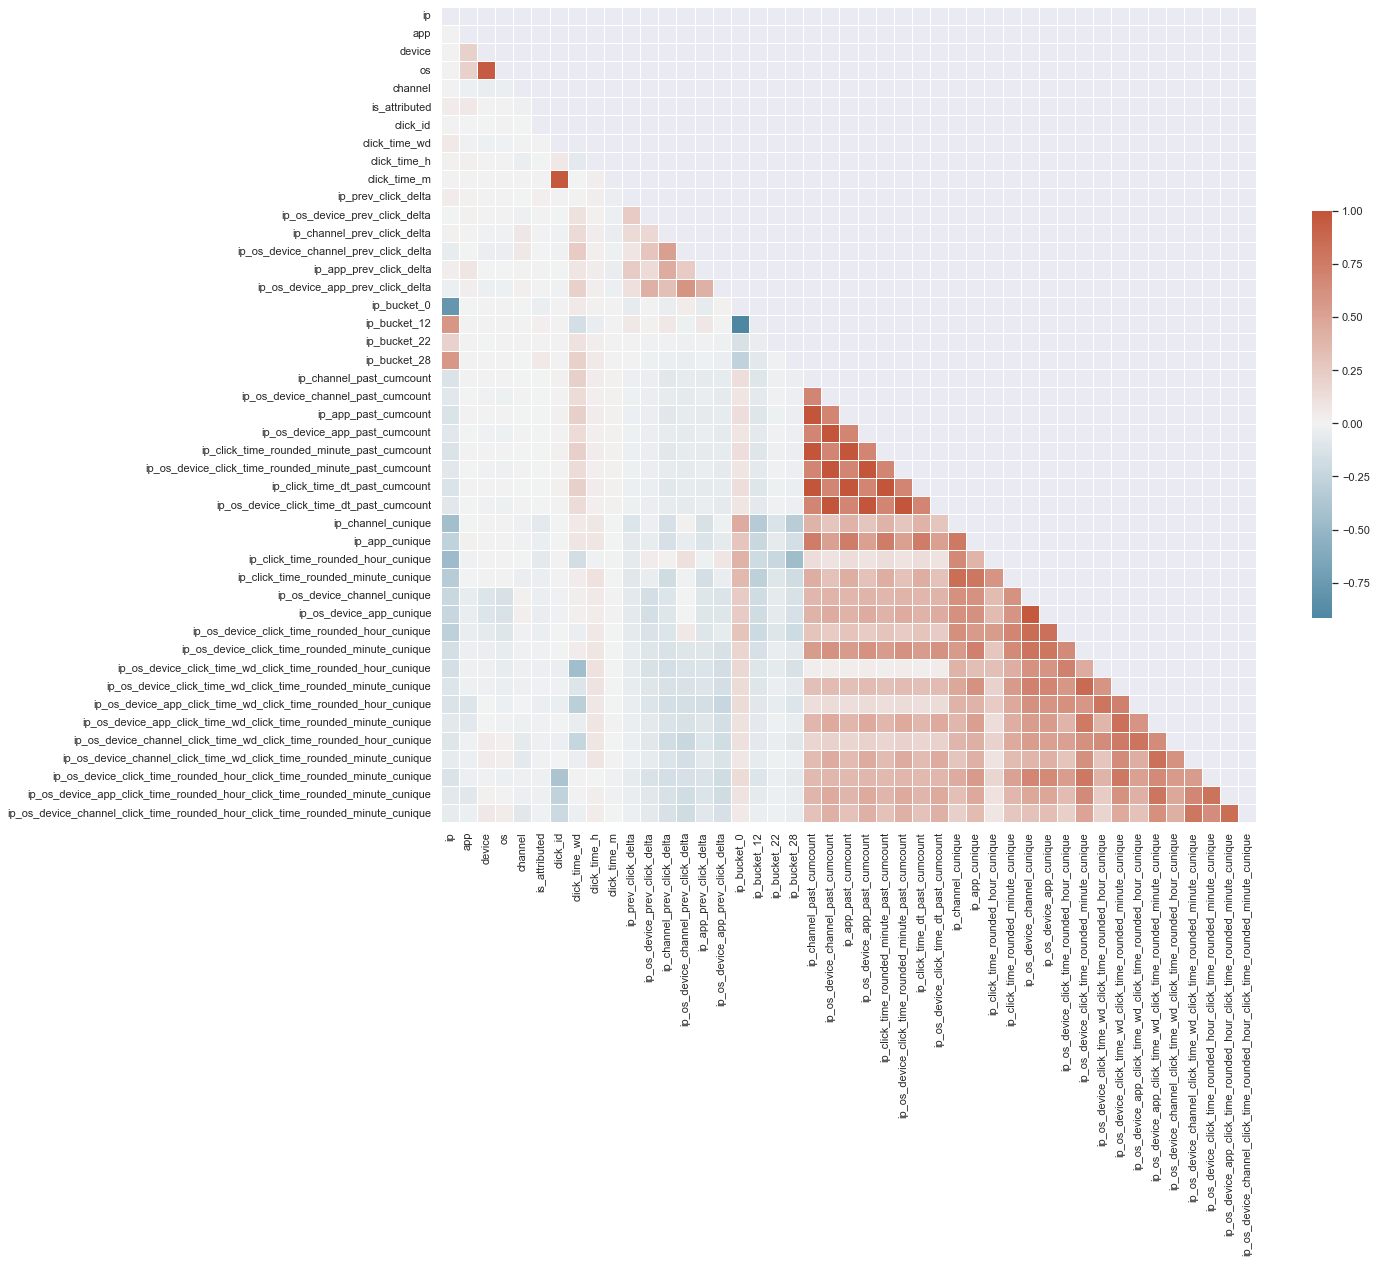

In [ ]:
features_correlation = train_test_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(features_correlation, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(features_correlation, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Potential features to remove:

- ip_channel_past_cumcount / ip_app_past_cumcount - Since app and channel are highly correlated
- ip_os_device_channel_past_cumcount / ip_os_device_app_past_cumcount - Since app and channel are highly correlated
- ip_os_device_app_cunique / ip_os_device_channel_cunique - Since app and channel are highly correlated


In [16]:
# Take the initial feature set

# Categorical features
cat_features_v2 = [
    'app',
    'device',
    'os',
    'channel',
    'click_time_wd',
    'click_time_h',
    'click_time_m']


time_delta_features = ['ip_prev_click_delta',
 'ip_os_device_prev_click_delta',
 'ip_channel_prev_click_delta',
 'ip_os_device_channel_prev_click_delta',
 'ip_app_prev_click_delta',
 'ip_os_device_app_prev_click_delta']


## IP bins
# Evaluate the original bins
ip_bins_v1 = ['ip_bucket_0',
 'ip_bucket_12',
 'ip_bucket_22',
 'ip_bucket_28']

# Evaluate smaller bins
ip_bins_v2 = [
    'ip_bucket_v2_0',
    'ip_bucket_v2_1',
    'ip_bucket_v2_2',
    'ip_bucket_v2_3',
    'ip_bucket_v2_4',
    'ip_bucket_v2_5',
    'ip_bucket_v2_6',
    'ip_bucket_v2_7',
    'ip_bucket_v2_8',
    'ip_bucket_v2_9',
    'ip_bucket_v2_10',
    'ip_bucket_v2_11',
    'ip_bucket_v2_12',
    'ip_bucket_v2_13',
    'ip_bucket_v2_14',
    'ip_bucket_v2_15',
    'ip_bucket_v2_16',
    'ip_bucket_v2_17',
    'ip_bucket_v2_18',
    'ip_bucket_v2_19',
    'ip_bucket_v2_20',
    'ip_bucket_v2_21',
    'ip_bucket_v2_22',
    'ip_bucket_v2_23',
    'ip_bucket_v2_24',
    'ip_bucket_v2_25',
    'ip_bucket_v2_26',
    'ip_bucket_v2_27',
    'ip_bucket_v2_28',
    'ip_bucket_v2_29',
    'ip_bucket_v2_30',
    'ip_bucket_v2_31',
    'ip_bucket_v2_32',
    'ip_bucket_v2_33',
    'ip_bucket_v2_34',
    'ip_bucket_v2_35',
    'ip_bucket_v2_36'
]

# Evaluate no bins at all
no_ip_bins = ['ip']

count_features_all = [  
 'ip_channel_past_cumcount',
 'ip_os_past_cumcount',
 'ip_device_past_cumcount',
 'ip_os_device_channel_past_cumcount',
 'ip_app_past_cumcount',
 'ip_os_device_app_past_cumcount',
 'ip_click_time_rounded_minute_past_cumcount',
 'ip_os_device_click_time_rounded_minute_past_cumcount',
 'ip_click_time_dt_past_cumcount',
 'ip_channel_click_time_dt_past_cumcount',
 'ip_app_click_time_dt_past_cumcount',
 'ip_os_device_click_time_dt_past_cumcount',
 'ip_os_device_channel_click_time_dt_past_cumcount',
 'ip_os_device_app_click_time_dt_past_cumcount',
 'ip_channel_cunique',
 'ip_app_cunique',
 'ip_click_time_rounded_hour_cunique',
 'ip_click_time_rounded_minute_cunique',
 'ip_os_device_channel_cunique',
 'ip_os_device_app_cunique',
 'ip_os_device_click_time_rounded_hour_cunique',
 'ip_os_device_click_time_rounded_minute_cunique',
 'ip_os_device_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_app_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_app_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_channel_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_channel_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_click_time_rounded_hour_click_time_rounded_minute_cunique',
 'ip_os_device_app_click_time_rounded_hour_click_time_rounded_minute_cunique',
 'ip_os_device_channel_click_time_rounded_hour_click_time_rounded_minute_cunique']

count_feature_no_high_correlation = [
#  'ip_channel_past_cumcount',
 'ip_os_past_cumcount',
 'ip_device_past_cumcount',
#  'ip_os_device_channel_past_cumcount',
 'ip_app_past_cumcount',
 'ip_os_device_app_past_cumcount',
 'ip_click_time_rounded_minute_past_cumcount',
 'ip_os_device_click_time_rounded_minute_past_cumcount',
 'ip_click_time_dt_past_cumcount',
 'ip_channel_click_time_dt_past_cumcount',
 'ip_app_click_time_dt_past_cumcount',
 'ip_os_device_click_time_dt_past_cumcount',
 'ip_os_device_channel_click_time_dt_past_cumcount',
 'ip_os_device_app_click_time_dt_past_cumcount',
 'ip_channel_cunique',
 'ip_app_cunique',
 'ip_click_time_rounded_hour_cunique',
 'ip_click_time_rounded_minute_cunique',
#  'ip_os_device_channel_cunique',
 'ip_os_device_app_cunique',
 'ip_os_device_click_time_rounded_hour_cunique',
 'ip_os_device_click_time_rounded_minute_cunique',
 'ip_os_device_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_app_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_app_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_channel_click_time_wd_click_time_rounded_hour_cunique',
 'ip_os_device_channel_click_time_wd_click_time_rounded_minute_cunique',
 'ip_os_device_click_time_rounded_hour_click_time_rounded_minute_cunique',
 'ip_os_device_app_click_time_rounded_hour_click_time_rounded_minute_cunique',
 'ip_os_device_channel_click_time_rounded_hour_click_time_rounded_minute_cunique'
 ]
 
feature_set_v2 = cat_features_v2 + time_delta_features + ip_bins_v1 + count_features_all

feature_set_v2_remove_high_corr_ip_bins_v1 = cat_features_v2 + time_delta_features + ip_bins_v1 + count_feature_no_high_correlation

feature_set_v2_remove_high_corr_ip_bins_v2 = cat_features_v2 + time_delta_features + ip_bins_v2 + count_feature_no_high_correlation

feature_set_v2_remove_high_corr_no_ip_bins = cat_features_v2 + time_delta_features + no_ip_bins + count_feature_no_high_correlation

##### Saving the datasets

In [ ]:
from datetime import datetime

train_validation_df.to_pickle(f'./datasets/ds_train_val_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')
train_test_df[train_test_df.ds_type=='train'].to_pickle(f'./datasets/ds_full_train_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')
train_test_df[train_test_df.ds_type=='test'].to_pickle(f'./datasets/ds_full_test_{datetime.now().strftime("%Y%m%d_%H%M")}.pkl')

gc.collect()

# Model Retraining

##### Loading the datasets

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np

In [18]:
train_val_df = pd.read_pickle('./datasets/ds_train_val_20220131_1407.pkl')
full_train_df = pd.read_pickle('./datasets/ds_full_train_20220131_1502.pkl')
full_test_df = pd.read_pickle('./datasets/ds_full_test_20220131_1504.pkl')


In [21]:
gc.collect()

0

In [19]:
# Split to train and validation
train_val_size = train_val_df.shape[0]
train_end = round(train_val_size * 0.86)
validation_start = round(train_val_size * 0.8605)

# Partial train (as part of train-validation split)
train_x = train_val_df[:train_end][[i for i in train_val_df.columns.tolist() if i != 'is_attributed']]
train_y = train_val_df[:train_end].is_attributed

# Validation
validation_x = train_val_df[validation_start:][[i for i in train_val_df.columns.tolist() if i != 'is_attributed']]
validation_y = train_val_df[validation_start:].is_attributed

# Full train
full_train_x = full_train_df[[i for i in full_train_df.columns.tolist() if i != 'is_attributed']]
full_train_y = full_train_df.is_attributed

# Test
test_x = full_test_df[[i for i in full_test_df.columns.tolist() if i != 'is_attributed']]
test_y = full_test_df.is_attributed

In [26]:
# Verify that split worked as expected:
print(f"Train start - {train_x.click_time_dt.min()}\nTrain end - {train_x.click_time_dt.max()}\nValidation start - {validation_x.click_time_dt.min()}\nValidation end - {validation_x.click_time_dt.max()}")


Train start - 2017-11-06 14:32:21
Train end - 2017-11-09 13:54:33
Validation start - 2017-11-09 13:54:46
Validation end - 2017-11-09 14:59:59


##### Sample weighting

Reminder for the conclusion from the baseline model:

"""
Sample weights - As we mentioned in our EDA, we would like to give different weight to different samples (here we only increased the positive sample weights), we need to think on the strategy here, some ideas we had:
 - Giving bigger sample weight to samples near the train end (as they are the closest to the test set).
 - Evaluating different weights over time (older samples - lower weight, newest - bigger weights).
 """

We will try to implement multiple weighting options and we will evaluate the best result using our validation set.

In [29]:
def generate_sample_weights(df_x, df_y, train_last_section_threshold, train_last_section_weight, positive_samples_weight):
    # Initialize all samples to weight=1
    train_weights = np.ones(df_x.shape[0])

    # Increase weight for positive samples
    train_weights[df_y==1] = positive_samples_weight

    # Increase the weight for samples that are near the train end (as they are probably more similar to the test / validation)
    train_end_idx = round(df_x.shape[0] * train_last_section_threshold)
    train_weights[train_end_idx:] = train_weights[train_end_idx:] * train_last_section_weight
    return train_weights

##### Set different experiments configurations

We've tried here multiple configurations that attempted to handle some of the issues we did not address in the baseline model such as:
- Weighting samples (samples closer to test time-wise should have bigger weight), we tried multiple variations of weighting
- Params optimization with Optuna
- Excluding highly correlated features, attempting different IP binning ranges (and not using binning at all)

Below are the top configurations that we've used.

In [56]:
# These are the best lightGBM params we got in the baseline model (might need some tweaking later).
seed=42

default_lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc', # This is the evaluation metric of our problem based on the kaggle evaluation
        'learning_rate': 0.001, 
        'max_bin': 100,  # Max bins per feature

        # 'num_leaves': 31, # We replaced this with optuna given value
        
        # Additional optuna params
        'feature_fraction': 0.7,
        'num_leaves': 152, # Read the docs and some common practices to avoid overfitting, took this number for start

        'random_state': seed
}

# default_lgb_params_pos_scale = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': 'auc', # This is the evaluation metric of our problem based on the kaggle evaluation
#         'learning_rate': 0.03, 
#         'num_leaves': 31, # Read the docs and some common practices to avoid overfitting, took this number for start
#         'max_bin': 100,  # Max bins per feature,
#         'scale_pos_weight': 200, # Trying to dealing with the imbalance problem
#         'random_state': seed
# }



configs = [
    # Did not work good - 
    # Include all new features + sample weights same in baseline (pos scale LGBM param = 200)
    # {"conf_name":"conf_baseline_pos_scale" ,"feature_set": (cat_features_v2, feature_set_v2),  
    #     "sample_weights": train_weights_v1, "model_params": default_lgb_params_pos_scale},

    # Did not work good - 
    # Include new features, remove high correlated + sample weights same in baseline (pos scale LGBM param = 200)
    # {"conf_name":"conf_baseline_pos_scale_remove_corr" ,"feature_set": (cat_features_v2, feature_set_v2_remove_high_corr),  
    #     "sample_weights": train_weights_v1, "model_params": default_lgb_params_pos_scale},


    # Did not work good - 
    # # Include all new features + sample weights V1 (train end - 0.95, train end weight * 5, positive sample weight * 200)
    # {"conf_name":"conf_v1" ,"feature_set": (cat_features_v2, feature_set_v2),  "sample_weights": train_weights_v1, "model_params": default_lgb_params},

    # Did not work good - 
    # # Include all new features + sample weights V2 (train end - 0.95, train end weight * 10, positive sample weight * 200)
    # {"conf_name":"conf_v2" ,"feature_set": (cat_features_v2, feature_set_v2),  "sample_weights": train_weights_v2, "model_params": default_lgb_params},

    # Did not work good - 
    # # Include all new features + sample weights V2 (train end - 0.90, train end weight * 10, positive sample weight * 200)
    # {"conf_name":"conf_v3" ,"feature_set": (cat_features_v2, feature_set_v2),  "sample_weights": train_weights_v3, "model_params": default_lgb_params},


    # Include new features + original IP bins from baseline model (0, 12, 28) + sample weights V1
    # { 
    #     "conf_name":"new_features_orig_ip_bins_weights_v1" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.90, 
    #         'train_last_section_weight': 10, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    ## No High Correlation + original IP bins
    # Include new features + original IP bins from baseline model (0, 12, 28), remove high correlated + sample weights V1
    { 
        "conf_name":"new_features_remove_corr_weights_v1" ,
        "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
        "sample_weights": {
            'train_last_section_threshold': 0.9, 
            'train_last_section_weight': 10, 
            "positive_samples_weight": 200
        }, 
        "model_params": default_lgb_params
    },

    # Include new features + original IP bins from baseline model (0, 12, 28), remove high correlated + sample weights V5
    { 
        "conf_name":"new_features_remove_corr_weights_v5" ,
        "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
        "sample_weights": {
            'train_last_section_threshold': 0.9, 
            'train_last_section_weight': 5, 
            "positive_samples_weight": 200
        }, 
        "model_params": default_lgb_params
    },

    # Include new features + original IP bins from baseline model (0, 12, 28), remove high correlated + sample weights V2
    # { 
    #     "conf_name":"remove_corr_weights_v2" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 10, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # Include new features + original IP bins from baseline model (0, 12, 28), remove high correlated + sample weights V3
    # { 
    #     "conf_name":"remove_corr_weights_v3" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.9, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # Include new features + original IP bins from baseline model (0, 12, 28), remove high correlated + sample weights V4
    # { 
    #     "conf_name":"remove_corr_weights_v4" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v1),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },




    ## No High Correlation + v2 IP bins bins
    # Include new features + IP bins v2, remove high correlated + sample weights V1
    { 
        "conf_name":"new_features_remove_corr_new_ip_bins_weights_v1" ,
        "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v2),  
        "sample_weights": {
            'train_last_section_threshold': 0.90, 
            'train_last_section_weight': 10, 
            "positive_samples_weight": 200
        }, 
        "model_params": default_lgb_params
    },

    { 
        "conf_name":"new_features_remove_corr_new_ip_bins_weights_v5" ,
        "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v2),  
        "sample_weights": {
            'train_last_section_threshold': 0.90, 
            'train_last_section_weight': 5, 
            "positive_samples_weight": 200
        }, 
        "model_params": default_lgb_params
    },

    # Include new features + IP bins v2, remove high correlated + sample weights V2
    # { 
    #     "conf_name":"remove_corr_weights_v2" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v2),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 10, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # Include new features + IP bins v2, remove high correlated + sample weights V3
    # { 
    #     "conf_name":"remove_corr_weights_v3" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v2),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.9, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # Include new features + IP bins v2, remove high correlated + sample weights V4
    # { 
    #     "conf_name":"remove_corr_weights_v4" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_ip_bins_v2),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },


    ## No High Correlation + no IP bins
    # Include new features + no IP bins, remove high correlated + sample weights V1
    # { 
    #     "conf_name":"remove_corr_weights_v1" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_no_ip_bins),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.90, 
    #         'train_last_section_weight': 10, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # Include new features + IP bins v2, remove high correlated + sample weights V2
    # { 
    #     "conf_name":"remove_corr_weights_v2" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_no_ip_bins),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 10, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # # Include new features + IP bins v2, remove high correlated + sample weights V3
    # { 
    #     "conf_name":"remove_corr_weights_v3" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_no_ip_bins),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.9, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # },

    # # Include new features + IP bins v2, remove high correlated + sample weights V4
    # { 
    #     "conf_name":"remove_corr_weights_v4" ,
    #     "feature_set": (cat_features_v2, feature_set_v2_remove_high_corr_no_ip_bins),  
    #     "sample_weights": {
    #         'train_last_section_threshold': 0.85, 
    #         'train_last_section_weight': 30, 
    #         "positive_samples_weight": 200
    #     }, 
    #     "model_params": default_lgb_params
    # }
]


### Gradient boosting models

##### LightGBM training method

In [61]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from datetime import datetime

def train_lgb(train_conf, train_x, train_y, validation_x=None, validation_y=None, n_iters=1000, early_stop=50, save_model=True):
    conf_name = train_conf.get('conf_name')
    cat_features, features = train_conf.get('feature_set')
    weights_params = train_conf.get('sample_weights')


    # Creating the datasets

    LOGGER.info(f"{conf_name} - Creating datasets for LightGBM training\n")

    LOGGER.info(f"{conf_name} - Generating sample's weights\n")
    weights = generate_sample_weights(train_x, 
                                      train_y, 
                                      weights_params.get('train_last_section_threshold'), 
                                      weights_params.get('train_last_section_weight'), 
                                      weights_params.get('positive_samples_weight'))
    lgb_params = train_conf.get('model_params')

    LOGGER.info(f"{conf_name} - Generating binary LGBM datasets\n")

    eval_sets = []
    eval_sets_names = []

    lgb_train = lgb.Dataset(train_x[features].values, label=train_y, feature_name=features, categorical_feature=cat_features, weight=weights)
    eval_sets.append(lgb_train)
    eval_sets_names.append('train')

    if validation_x is not None:
        lgb_valid = lgb.Dataset(validation_x[features].values, label=validation_y, feature_name=features, categorical_feature=cat_features)
        eval_sets.append(lgb_valid)
        eval_sets_names.append('validation')
    gc.collect()

    callbacks=[log_evaluation(1)]
    if early_stop:
        callbacks.append(early_stopping(early_stop))

    LOGGER.info(f"{conf_name} - Starting the fitting process\n")
    results = {}
    clf_lgb = lgb.train(lgb_params, 
                    lgb_train, 
                    valid_sets=eval_sets, 
                    valid_names=eval_sets_names,
                    evals_result=results, 
                    callbacks=callbacks,
                    num_boost_round=n_iters)

    train_auc = results['train']['auc'][clf_lgb.best_iteration-1]
    valid_auc = None
    
    if validation_x is not None:
        valid_auc = results['validation']['auc'][clf_lgb.best_iteration-1]
    

    LOGGER.info(f"{conf_name} - Fitting completed | Train AUC - [{train_auc}] | Validation AUC [{valid_auc}]")

    if save_model:
        clf_lgb.save_model(f'./models/lgbm_model_{conf_name}_{datetime.now().strftime("%Y%m%d_%H%M")}.lgbm')
    
    return clf_lgb, train_auc, valid_auc


In [62]:
models = []

for training_conf in configs:
    conf_name = training_conf.get('conf_name')
    clf_lgb, train_auc, valid_auc = train_lgb(training_conf, train_x, train_y, validation_x, validation_y)
    models.append({"conf_name": conf_name, "clf": clf_lgb, "train_auc": train_auc, "valid_auc": valid_auc, "model_conf": training_conf})


01/31/2022 05:13:00PM | INFO | BasicLogger | new_features_remove_corr_weights_v1 - Creating datasets for LightGBM training

01/31/2022 05:13:00PM | INFO | BasicLogger | new_features_remove_corr_weights_v1 - Generating sample's weights

01/31/2022 05:13:00PM | INFO | BasicLogger | new_features_remove_corr_weights_v1 - Generating binary LGBM datasets

01/31/2022 05:13:37PM | INFO | BasicLogger | new_features_remove_corr_weights_v1 - Starting the fitting process



[LightGBM] [Info] Number of positive: 56288, number of negative: 23058211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.784346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3216
[LightGBM] [Info] Number of data points in the train set: 23114499, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334089 -> initscore=-0.689748
[LightGBM] [Info] Start training from score -0.689748
[1]	train's auc: 0.97351	validation's auc: 0.954208
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.976792	validation's auc: 0.967555
[3]	train's auc: 0.977603	validation's auc: 0.969695
[4]	train's auc: 0.97794	validation's auc: 0.97117
[5]	train's auc: 0.978067	validation's auc: 0.97198
[6]	train's auc: 0.978192	validation's auc: 0.969762
[7]	train's auc: 0.978613	validation's auc: 0.969755
[8]	t

01/31/2022 05:35:14PM | INFO | BasicLogger | new_features_remove_corr_weights_v1 - Fitting completed | Train AUC - [0.994927928705803] | Validation AUC [0.9746028899866759]
01/31/2022 05:35:14PM | INFO | BasicLogger | new_features_remove_corr_weights_v5 - Creating datasets for LightGBM training

01/31/2022 05:35:14PM | INFO | BasicLogger | new_features_remove_corr_weights_v5 - Generating sample's weights

01/31/2022 05:35:14PM | INFO | BasicLogger | new_features_remove_corr_weights_v5 - Generating binary LGBM datasets

01/31/2022 05:35:48PM | INFO | BasicLogger | new_features_remove_corr_weights_v5 - Starting the fitting process



[LightGBM] [Info] Number of positive: 56288, number of negative: 23058211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.762842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3216
[LightGBM] [Info] Number of data points in the train set: 23114499, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331709 -> initscore=-0.700466
[LightGBM] [Info] Start training from score -0.700466
[1]	train's auc: 0.972825	validation's auc: 0.954666
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.975687	validation's auc: 0.969511
[3]	train's auc: 0.975924	validation's auc: 0.971396
[4]	train's auc: 0.976218	validation's auc: 0.97205
[5]	train's auc: 0.976318	validation's auc: 0.972521
[6]	train's auc: 0.976107	validation's auc: 0.969727
[7]	train's auc: 0.97603	validation's auc: 0.969977
[8]

01/31/2022 06:04:28PM | INFO | BasicLogger | new_features_remove_corr_weights_v5 - Fitting completed | Train AUC - [0.9958576797596312] | Validation AUC [0.9753948197693374]
01/31/2022 06:04:30PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v1 - Creating datasets for LightGBM training

01/31/2022 06:04:30PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v1 - Generating sample's weights

01/31/2022 06:04:30PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v1 - Generating binary LGBM datasets

01/31/2022 06:05:13PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v1 - Starting the fitting process



[LightGBM] [Info] Number of positive: 56288, number of negative: 23058211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.411399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 23114499, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334089 -> initscore=-0.689748
[LightGBM] [Info] Start training from score -0.689748
[1]	train's auc: 0.970901	validation's auc: 0.960849
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.973999	validation's auc: 0.967553
[3]	train's auc: 0.976781	validation's auc: 0.969937
[4]	train's auc: 0.977589	validation's auc: 0.967653
[5]	train's auc: 0.977919	validation's auc: 0.968329
[6]	train's auc: 0.978587	validation's auc: 0.969699
[7]	train's auc: 0.978797	validation's auc: 0.969875
[

01/31/2022 06:23:23PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v1 - Fitting completed | Train AUC - [0.9933053181103771] | Validation AUC [0.9749145926398418]
01/31/2022 06:23:24PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v5 - Creating datasets for LightGBM training

01/31/2022 06:23:24PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v5 - Generating sample's weights

01/31/2022 06:23:24PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v5 - Generating binary LGBM datasets

01/31/2022 06:24:04PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v5 - Starting the fitting process



[LightGBM] [Info] Number of positive: 56288, number of negative: 23058211
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.480587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3282
[LightGBM] [Info] Number of data points in the train set: 23114499, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331709 -> initscore=-0.700466
[LightGBM] [Info] Start training from score -0.700466
[1]	train's auc: 0.971021	validation's auc: 0.963908
Training until validation scores don't improve for 50 rounds
[2]	train's auc: 0.973271	validation's auc: 0.96793
[3]	train's auc: 0.974973	validation's auc: 0.969356
[4]	train's auc: 0.97511	validation's auc: 0.967898
[5]	train's auc: 0.975161	validation's auc: 0.96818
[6]	train's auc: 0.975809	validation's auc: 0.969755
[7]	train's auc: 0.976175	validation's auc: 0.969636
[8]	

01/31/2022 06:51:01PM | INFO | BasicLogger | new_features_remove_corr_new_ip_bins_weights_v5 - Fitting completed | Train AUC - [0.9921550729682876] | Validation AUC [0.9751701091782671]


In [70]:
print("(Conf name, Train AUC, Validation AUC)") 

for result in [(m.get('conf_name'), m.get('train_auc'), m.get('valid_auc')) for m in models]:
    print(result)

(Conf name, Train AUC, Validation AUC)
('new_features_remove_corr_weights_v1', 0.994927928705803, 0.9746028899866759)
('new_features_remove_corr_weights_v5', 0.9958576797596312, 0.9753948197693374)
('new_features_remove_corr_new_ip_bins_weights_v1', 0.9933053181103771, 0.9749145926398418)
('new_features_remove_corr_new_ip_bins_weights_v5', 0.9921550729682876, 0.9751701091782671)


Accoring to the validation scores the best model is the model with configuration name - new_features_remove_corr_weights_v5

The results:
- Train AUC: 0.9958576797596312
- Validation AUC: 0.9753948197693374
- Best iteration: 277

So we see that higher weights on the latest 5% of the samples + removing highly correlated features yields the best results.


##### Let's take a look on the model errors and important features

In [75]:
import lightgbm as lgb
clf_best_train_validation = lgb.Booster(model_file='./models/lgbm_model_final_model_new_features_remove_corr_weights_v5_20220131_1939.lgbm')

analized_model = clf_best_train_validation
best_feature_set = feature_set_v2_remove_high_corr_ip_bins_v1

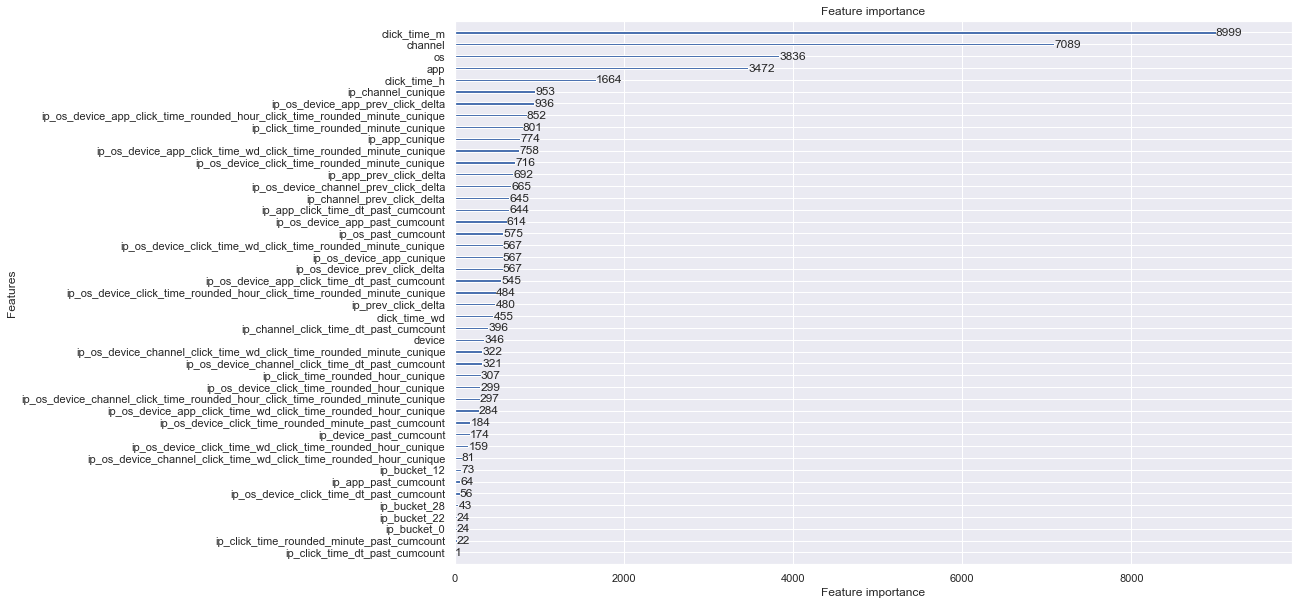

In [72]:
lgb.plot_importance(analized_model, max_num_features=100, figsize=(15, 10))
plt.show()

In [76]:
def get_predictions(df_x, clf, feature_set):
    return clf.predict(df_x[feature_set])

def get_fns(df_x, y_pred, y_true):
    '''
    input: df_x, y_pred, y_true dataframes
    output: false-negavites samples
    '''
    return df_x[(y_true==1) & (y_true!=y_pred)]

def get_fps(df_x, y_pred, y_true):
    '''
    input: df_x, y_pred, y_true dataframes
    output: false-positives samples
    '''
    return df_x[(y_true==0) & (y_true!=y_pred)]

def plot_errors_hist(errors_df, full_df, features_to_plot):
    plt.figure(figsize=(15,15))
    
    features = features_to_plot
    features_size = len(features)
    i = 1
    
    for feature in features:
        plt.subplot(features_size, 2, i)
        errors_df[feature].hist(alpha=0.5, color='blue', bins=50, label='errors')
        plt.legend()
        plt.title(f'{feature} values for errors samples')
        plt.xlabel(feature)

        plt.subplot(features_size, 2, i+1)
        full_df[feature].hist(alpha=0.5, color='red', bins=50, label='full data')
        plt.title(f'{feature} values for full data samples')
        plt.legend()
        plt.xlabel(feature)
        i+= 2
    plt.tight_layout()


In [77]:
train_preds = get_predictions(train_x, analized_model, best_feature_set)
validation_preds = get_predictions(validation_x, analized_model, best_feature_set)

train_classification_preds = np.where(train_preds>0.5, 1, 0)
validation_classification_preds = np.where(validation_preds>0.5, 1, 0)

train_results_df = train_x.copy()
train_results_df['y_true'] = train_y
train_results_df['y_preds'] = train_classification_preds


val_results_df = validation_x.copy()
val_results_df['y_true'] = validation_y
val_results_df['y_preds'] = validation_classification_preds

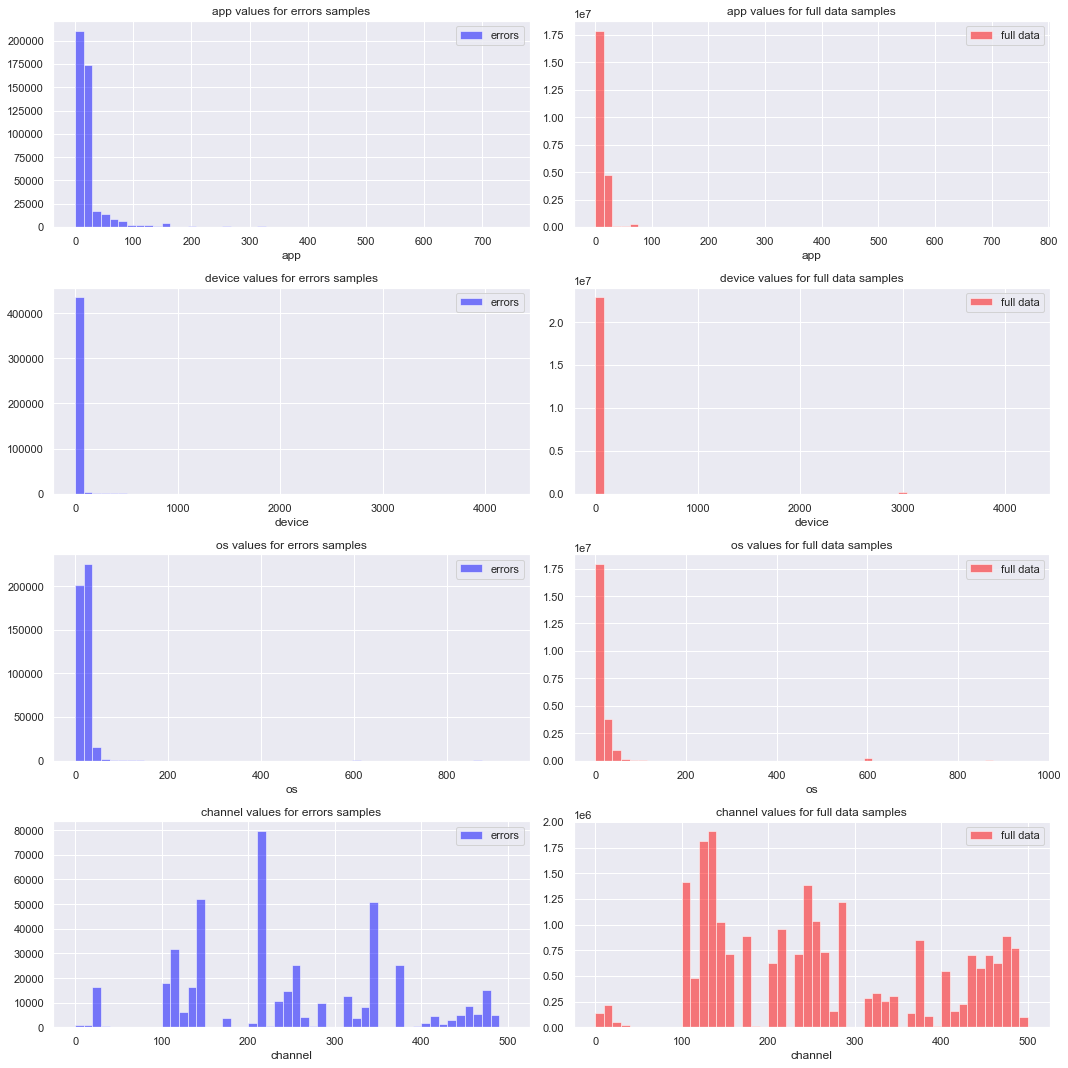

In [79]:
features_to_plot = ['app', 'device', 'os', 'channel']
plot_errors_hist(train_results_df[train_results_df.y_true != train_results_df.y_preds], train_results_df, features_to_plot)

##### Confusion Matrix

<AxesSubplot:>

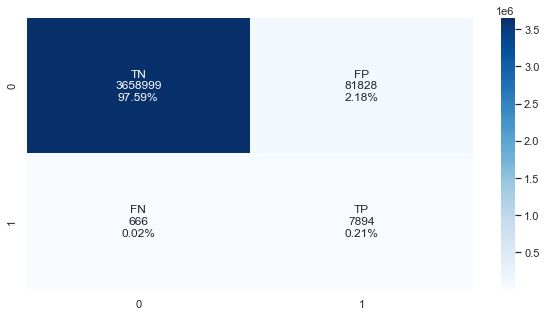

In [81]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(val_results_df.y_true, val_results_df.y_preds)


group_names = ['TN','FP','FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

### Final model training & prediction


We will use the lightGBM model with the same params we've found in the training on train+validation.

This time we will train on the entire train set and predict on the test set.

##### Fitting

In [64]:
final_models = []

for model in models:

        conf_name = 'final_model_' + model.get('conf_name')
        model_conf = model.get('model_conf').copy()
        model_conf['conf_name'] =  conf_name
        trained_clf = model.get('clf')
        best_iteration = trained_clf.best_iteration

        final_model = train_lgb(train_conf=model_conf,
            train_x=full_train_x,
            train_y=full_train_y,
            n_iters=best_iteration,
            early_stop=None)[0]
        
        final_models.append((final_model, model_conf))
        gc.collect()

01/31/2022 06:51:02PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v1 - Creating datasets for LightGBM training

01/31/2022 06:51:02PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v1 - Generating sample's weights

01/31/2022 06:51:02PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v1 - Generating binary LGBM datasets

01/31/2022 06:51:49PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v1 - Starting the fitting process



[LightGBM] [Info] Number of positive: 64876, number of negative: 26812448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.027790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3212
[LightGBM] [Info] Number of data points in the train set: 26877324, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.319672 -> initscore=-0.755281
[LightGBM] [Info] Start training from score -0.755281
[1]	train's auc: 0.975667
[2]	train's auc: 0.97819
[3]	train's auc: 0.978839
[4]	train's auc: 0.979754
[5]	train's auc: 0.979899
[6]	train's auc: 0.980419
[7]	train's auc: 0.98102
[8]	train's auc: 0.981156
[9]	train's auc: 0.981464
[10]	train's auc: 0.981673
[11]	train's auc: 0.982031
[12]	train's auc: 0.982083
[13]	train's auc: 0.982375
[14]	train's auc: 0.982264
[15]	train's auc: 0.982149
[16]	train's auc: 0.982211
[17]	train's

01/31/2022 07:11:41PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v1 - Fitting completed | Train AUC - [0.9952008761441326] | Validation AUC [None]
01/31/2022 07:11:42PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v5 - Creating datasets for LightGBM training

01/31/2022 07:11:42PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v5 - Generating sample's weights

01/31/2022 07:11:42PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v5 - Generating binary LGBM datasets

01/31/2022 07:12:17PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v5 - Starting the fitting process



[LightGBM] [Info] Number of positive: 64876, number of negative: 26812448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.088731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3212
[LightGBM] [Info] Number of data points in the train set: 26877324, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322242 -> initscore=-0.743489
[LightGBM] [Info] Start training from score -0.743489
[1]	train's auc: 0.973411
[2]	train's auc: 0.975868
[3]	train's auc: 0.976374
[4]	train's auc: 0.976898
[5]	train's auc: 0.9772
[6]	train's auc: 0.977322
[7]	train's auc: 0.977199
[8]	train's auc: 0.97747
[9]	train's auc: 0.977775
[10]	train's auc: 0.977766
[11]	train's auc: 0.977955
[12]	train's auc: 0.977993
[13]	train's auc: 0.9784
[14]	train's auc: 0.978536
[15]	train's auc: 0.978688
[16]	train's auc: 0.978782
[17]	train's au

01/31/2022 07:39:24PM | INFO | BasicLogger | final_model_new_features_remove_corr_weights_v5 - Fitting completed | Train AUC - [0.9959065825584598] | Validation AUC [None]
01/31/2022 07:39:24PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v1 - Creating datasets for LightGBM training

01/31/2022 07:39:24PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v1 - Generating sample's weights

01/31/2022 07:39:25PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v1 - Generating binary LGBM datasets

01/31/2022 07:40:03PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v1 - Starting the fitting process



[LightGBM] [Info] Number of positive: 64876, number of negative: 26812448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.393381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3278
[LightGBM] [Info] Number of data points in the train set: 26877324, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.319672 -> initscore=-0.755281
[LightGBM] [Info] Start training from score -0.755281
[1]	train's auc: 0.972287
[2]	train's auc: 0.977283
[3]	train's auc: 0.979559
[4]	train's auc: 0.979806
[5]	train's auc: 0.980319
[6]	train's auc: 0.980569
[7]	train's auc: 0.980918
[8]	train's auc: 0.980817
[9]	train's auc: 0.980618
[10]	train's auc: 0.981318
[11]	train's auc: 0.981753
[12]	train's auc: 0.982212
[13]	train's auc: 0.982435
[14]	train's auc: 0.982393
[15]	train's auc: 0.982481
[16]	train's auc: 0.982759
[17]	train

01/31/2022 07:57:34PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v1 - Fitting completed | Train AUC - [0.9935758455612304] | Validation AUC [None]
01/31/2022 07:57:35PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v5 - Creating datasets for LightGBM training

01/31/2022 07:57:35PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v5 - Generating sample's weights

01/31/2022 07:57:35PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v5 - Generating binary LGBM datasets

01/31/2022 07:58:29PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v5 - Starting the fitting process



[LightGBM] [Info] Number of positive: 64876, number of negative: 26812448
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.627895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3278
[LightGBM] [Info] Number of data points in the train set: 26877324, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.322242 -> initscore=-0.743489
[LightGBM] [Info] Start training from score -0.743489
[1]	train's auc: 0.970611
[2]	train's auc: 0.973444
[3]	train's auc: 0.976057
[4]	train's auc: 0.976284
[5]	train's auc: 0.976407
[6]	train's auc: 0.976932
[7]	train's auc: 0.977151
[8]	train's auc: 0.977031
[9]	train's auc: 0.976659
[10]	train's auc: 0.977401
[11]	train's auc: 0.977832
[12]	train's auc: 0.978253
[13]	train's auc: 0.97851
[14]	train's auc: 0.978463
[15]	train's auc: 0.978684
[16]	train's auc: 0.979067
[17]	train'

01/31/2022 08:18:19PM | INFO | BasicLogger | final_model_new_features_remove_corr_new_ip_bins_weights_v5 - Fitting completed | Train AUC - [0.9921713456779936] | Validation AUC [None]


### Generate test predictions

In [65]:
def eval_test_preds(clf, clf_conf, test_x):

    feature_set = clf_conf.get("feature_set")[1]
    test_x = test_x.copy()
    test_x['is_attributed'] = clf.predict(test_x[feature_set])

    res = test_x[['click_id', 'is_attributed']].rename({'click_id': 'Id', 'is_attributed': 'Expected'}, axis=1)
    res.Id = res.Id.astype(np.int64)

    save_path = f'./predictions/test_preds_{clf_conf.get("conf_name")}_{datetime.now().strftime("%Y%m%d_%H%M")}.csv'

    res.to_csv(save_path, index=False)
    LOGGER.info(f'Saved latest test results to: {save_path}')

In [66]:
for final_model, final_model_conf in final_models:
    LOGGER.info(f'Saving test predictions for model: {final_model_conf.get("conf_name")}')
    eval_test_preds(final_model, final_model_conf, test_x)

01/31/2022 08:18:20PM | INFO | BasicLogger | Saving test predictions for model: final_model_new_features_remove_corr_weights_v1
01/31/2022 08:19:02PM | INFO | BasicLogger | Saved latest test results to: ./predictions/test_preds_final_model_new_features_remove_corr_weights_v1_20220131_2018.csv
01/31/2022 08:19:02PM | INFO | BasicLogger | Saving test predictions for model: final_model_new_features_remove_corr_weights_v5
01/31/2022 08:20:00PM | INFO | BasicLogger | Saved latest test results to: ./predictions/test_preds_final_model_new_features_remove_corr_weights_v5_20220131_2019.csv
01/31/2022 08:20:00PM | INFO | BasicLogger | Saving test predictions for model: final_model_new_features_remove_corr_new_ip_bins_weights_v1
01/31/2022 08:20:38PM | INFO | BasicLogger | Saved latest test results to: ./predictions/test_preds_final_model_new_features_remove_corr_new_ip_bins_weights_v1_20220131_2020.csv
01/31/2022 08:20:38PM | INFO | BasicLogger | Saving test predictions for model: final_model_ne

### Gaps & next items
- We see that due to the leakage problem, we did not improve our best test results from the baseline model (which had "too good" results due to that leakage), once we fixed the leakage, we believe we get stable model that can really work in production (although we did not improve the kaggle final test result).
- We did not use cross validation due to time limitations, we had technical problems with it and we did not get to it.
    - We planned to use TimeSeriesSplit and BlockedCross (increasing the lookback on train and maintaining 10% for validation vs. splitting to predefined block sizes).
- Another area that could have yielded improvements is actual error analysis
    - Based on the model's FPs / FNs feature values
    - SHAP analysis
- We used LightGBM as we had decent results in the baseline model, although trying different models (like catboost / XGBoost) could have yielded better results.
    - Potentially we could have used stacking as well here to get another boost in our results.
